##### Premissas Modelos Paramétricos:
- Outliers 
- Nulos 
- Distribuicao dos dados (p-valor >= 0.05)
- Correlação 

In [5]:
import pandas as pd
import catboost
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import xgboost as xgb
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import statistics
import sys
import os
from typing import List
import seaborn as sns
import sklearn
from scipy import stats
import matplotlib as plt
import numpy
from scipy.stats import shapiro, boxcox
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from scipy.stats import spearmanr
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'catboost'

In [ ]:

df1 = pd.read_csv("data/sabesp_cf.csv", sep=";",encoding='cp1252')
df2 = pd.read_csv("data/inmet.csv", sep=";", encoding='cp1252')

##### Transformações iniciais

In [ ]:
def split_date(df_raw:pd.DataFrame, date_col_name:str) -> pd.DataFrame:
    """Função realiza a separação da coluna data, utilizando como caracter de separação o /. 
    Inicialmente tinhamos uma data no formato 2022/04/11 e o objetivo é a separação criando 3 novas colunas:
    Dia, Mes e Ano. Desta forma, podemos utilizar como uma features de entrada para o nosso modelo de Machine Learning.

    Args:
        df_raw (pd.DataFrame): Dataframe raw, sem nenhum tratamento inicial.
        col_name (str): Nome da coluna de data que precisa ser transformada.

    Returns:
        pd.DataFrame: Dataframe com a coluna data, transformada em novas 3 colunas. 
    """

    df_raw[["DdDia", "MmMes", "AaAno"]] = df_raw[date_col_name].str.split("/", expand = True).astype(int)
    df_raw = df_raw.drop(date_col_name, axis=1)
    return df_raw

In [ ]:
def converting_str_to_float(df_raw: pd.DataFrame, cols_to_float: List[str])->pd.DataFrame:
  """Função converte todas as colunas do Dataframe que são do tipo string para float. Por estarmos
  construindo um modelo de regressão linear,  nossas entradas precisam obrigatoriamente ser numéricas.
  Primeiramente substituimos , por . e então convertemos a variável para o tipo float.

  Args:
      df_raw (pd.DataFrame): Dataframe raw, sem nenhum tratamento inicial.
      cols_to_float (List[str]): Lista contendo todos os nomes de colunas que precisam ser convertidas em float.
  Returns:
      pd.DataFrame: Dataframe com as colunas convertidas de string para float.
  """
  #Perceba que o nosso dataframe já recebe a função onde a data foi tratada e dividida em 3 novas colunas de data.
  for col in df_raw:
    if col in cols_to_float:
        df_raw[col] = df_raw[col].str.replace(',', '.').astype(float)
    else:
       df_raw[col] = df_raw[col].astype(int)
  return df_raw    

In [ ]:
def rename_cols(df_raw:pd.DataFrame, new_col_names:List[str]) -> pd.DataFrame:
    """Função renomeia colunas afim de, uma maior organização e padonização de variáveis. A regra considerada para a nomenclatura das colunas segue:
    Mnemonico|NomeDaColuna. Repare que o nome da coluna segue a convenção de developers CamelCase.
    Mnemonico ---------- Significado
        Aa               Coluna refere-se a dados do tipo Int, simbolizando ano.
        Ds               Coluna refere-se a dados do tipo string, simbolizando descrição.
        Dd               Coluna refere-se a dados do tipo Int, simbolizando dia.
        Mm               Coluna refere-se a dados do tipo Int, simbolizando mês.
        Vl               Coluna refere-se a dados do tipo float, simbolizando volume.
        Vr               Coluna refere-se a dados do tipo float, simbolizando valor.
        Vz               Coluna refere-se a dados do tipo float, simbolizando vazão.
        Pc               Coluna refere-se a dados do tipo float, simbolizando porcentagem.
    Args:
        df_raw (pd.DataFrame): Dataframe raw, sem nenhum tratamento inicial.
        new_col_names (List[str]): Lista com os novos nomes para as colunas do Dataframe, seguindo regras definida.

    Returns:
        pd.DataFrame: Dataframe com colunas renomeadas.
    """
    df_raw.columns = new_col_names
    
    return df_raw

In [ ]:
def pre_process_df1(df_raw:pd.DataFrame, date_col_name:str, cols_to_float: List[str], new_col_names:List[str])->pd.DataFrame:
    df1 = split_date(df_raw, date_col_name)
    df1 = converting_str_to_float(df1, cols_to_float)
    df1 = rename_cols(df1,new_col_names)
    return df1

In [ ]:
def pre_process_df2(df_raw: pd.DataFrame, date_col_name: str, new_col_names: List[str]) -> pd.DataFrame:
    df2 = split_date(df_raw, date_col_name)
    df2 = rename_cols(df2,new_col_names)
    return df2

##### Processamento inicial das 2 tabelas

In [ ]:
tb1 = pre_process_df1(df_raw = df1, date_col_name="ï»¿Data", cols_to_float =["NÃ­vel (m)", "Volume (hmÂ³)", "Volume (%)", "Q Jusante (mÂ³/s)", "Q Natural (mÂ³/s)", "Chuva (mm)"], new_col_names=["VrNivel" , "VlVolume", "PcVolume", "VzQJusante", "VzQNatural","VrChuva", "DdDia", "MmMes", "AaAno"])

In [ ]:
tb2 = pre_process_df2(df_raw = df2, date_col_name='Data', new_col_names=['DsLocal', 'VrTempMin', 'VrTempMed', 'VrTempMax', 'VrUmidadeArMin', 'VrUmidadeArMed', 'VrUmidadeArMax', 'VrPrecipitacao', "DdDia", "MmMes", "AaAno"])

##### Juntando tabelas

In [ ]:
def join_df(tb1: pd.DataFrame, tb2: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(tb1, tb2,  how='left', left_on=["DdDia", "MmMes", "AaAno"], right_on = ["DdDia", "MmMes", "AaAno"])
    df = df.drop('DsLocal', axis=1)
    #drop rows based in data where < 26/05/2008
    df = df.drop(df[(((df.AaAno <= 2008) & (df.MmMes <= 5) & (df.DdDia < 26)))].index)
    return df

In [ ]:
def create_abt(tb1: pd.DataFrame, tb2: pd.DataFrame, cols_to_transoform:List[str]):
    df = pre_process_df1(df_raw = df1, date_col_name="ï»¿Data", cols_to_float =["NÃ­vel (m)", "Volume (hmÂ³)", "Volume (%)", "Q Jusante (mÂ³/s)", "Q Natural (mÂ³/s)", "Chuva (mm)"], new_col_names=["VrNivel" , "VlVolume", "PcVolume", "VzQJusante", "VzQNatural","VrChuva", "DdDia", "MmMes", "AaAno"])
    #outliers
    df = df.drop(df[(df.VrUmidadeArMin < 10)].index)
    df = df.drop(df[(df.VrUmidadeArMax <= 93)].index)
    df = df.drop(df[(df.VrUmidadeArMed < 50)].index)
    df = df.drop(df[(df.VrPrecipitacao > 2)].index)
    df = df.drop(df[(df.VrTempMin <= 2)].index)
    df.drop(df[((df.VrTempMed < 2) | (df.VrTempMed >= 30))].index)
    df = df.drop(df[((df.VrTempMax < 0) | (df.VrTempMax >= 40))].index)
    df = df.drop(df[(df.VrNivel <= 629)].index)
    df = df.drop(df[(df.VlVolume < 0)].index)
    df = df.drop(df[(df.VzQJusante >= 35)].index)
    df = df.drop(df[((df.VzQNatural < -2) | (df.VzQNatural >= 30))].index)
    df = df.drop(df[(df.VrChuva > 2)].index)
    #Regra utilizada: média do mesmo mês do ano anterior, e, caso não exista ano anterior, preenche com a média geral de todos os anos.
    #ordena df
    df = df.sort_values(by=['AaAno', 'MmMes'])

    for coluna in cols_to_transoform:
        if df[coluna].isnull().any():
        # média dos valores não nulos do ano anterior e mesmo mês
            media_mes_ano_anterior = df.groupby(['AaAno', 'MmMes'])[coluna].shift().groupby(df['AaAno']).transform('mean')
            
            # média geral de todos os anos para os valores não nulos
            media_geral = df[coluna].mean()
            
            # preenche os valores NaN na coluna específica com a média do ano e mês anterior,
            # e, caso não exista ano anterior, preencha com a média geral
            df[coluna] = df[coluna].fillna(media_mes_ano_anterior.fillna(media_geral))

        return df

### Análise Descritiva (EDA) - 

#### Feeling Missing values

In [ ]:
df = join_df(tb1, tb2)

In [ ]:
df.count()

VrNivel           7587
VlVolume          7587
PcVolume          7587
VzQJusante        7587
VzQNatural        7587
VrChuva           7587
DdDia             7587
MmMes             7587
AaAno             7587
VrTempMin         5304
VrTempMed         5316
VrTempMax         5316
VrUmidadeArMin    4631
VrUmidadeArMed    5316
VrUmidadeArMax    4631
VrPrecipitacao    5316
dtype: int64

In [ ]:
def count_not_null(df:pd.DataFrame):
    for col in df:
        null = df[col].notnull().sum()
        print(f"{col}:{null}")

In [ ]:
def count_is_null(df:pd.DataFrame):
    for col in df:
        null = df[col].isnull().sum()
        print(f"{col}:{null}")

In [ ]:
count_not_null(df)

VrNivel:7587
VlVolume:7587
PcVolume:7587
VzQJusante:7587
VzQNatural:7587
VrChuva:7587
DdDia:7587
MmMes:7587
AaAno:7587
VrTempMin:5304
VrTempMed:5316
VrTempMax:5316
VrUmidadeArMin:4631
VrUmidadeArMed:5316
VrUmidadeArMax:4631
VrPrecipitacao:5316


##### Tratando outliers

In [ ]:
#Ao limpar dataframe começar sempre do que tem menor valor para o que tem maior

VrNivel           7586
VlVolume          7586
PcVolume          7586
VzQJusante        7586
VzQNatural        7586
VrChuva           7586
DdDia             7586
MmMes             7586
AaAno             7586
VrTempMin         5303
VrTempMed         5315
VrTempMax         5315
VrUmidadeArMin    4630
VrUmidadeArMed    5315
VrUmidadeArMax    4630
VrPrecipitacao    5315
dtype: int64

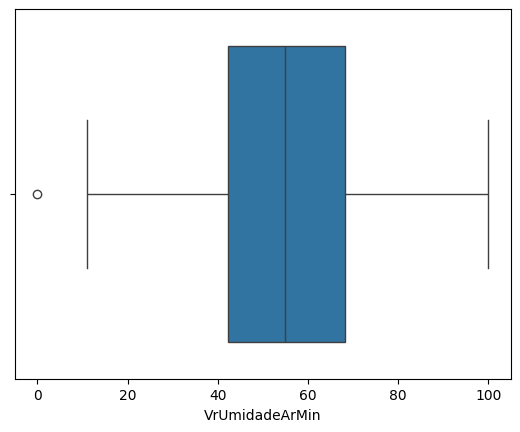

In [ ]:
#VrUmidadeArMin:4631
sns.boxplot(x= df["VrUmidadeArMin"])
df = df.drop(df[(df.VrUmidadeArMin < 10)].index)
df.count()

VrNivel           7436
VlVolume          7436
PcVolume          7436
VzQJusante        7436
VzQNatural        7436
VrChuva           7436
DdDia             7436
MmMes             7436
AaAno             7436
VrTempMin         5153
VrTempMed         5165
VrTempMax         5165
VrUmidadeArMin    4480
VrUmidadeArMed    5165
VrUmidadeArMax    4480
VrPrecipitacao    5165
dtype: int64

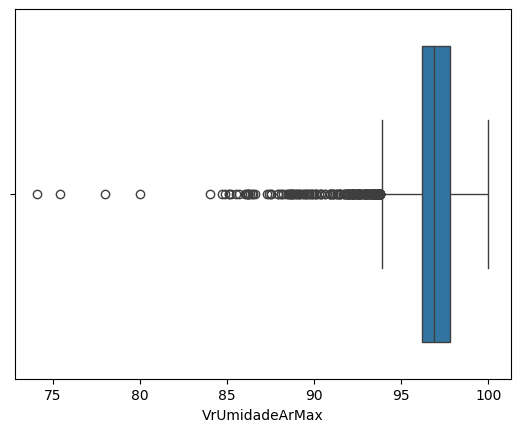

In [ ]:
#VrUmidadeArMax:4630
sns.boxplot(x= df["VrUmidadeArMax"])
df = df.drop(df[(df.VrUmidadeArMax <= 93)].index)
df.count()

VrNivel           6751
VlVolume          6751
PcVolume          6751
VzQJusante        6751
VzQNatural        6751
VrChuva           6751
DdDia             6751
MmMes             6751
AaAno             6751
VrTempMin         4468
VrTempMed         4480
VrTempMax         4480
VrUmidadeArMin    4480
VrUmidadeArMed    4480
VrUmidadeArMax    4480
VrPrecipitacao    4480
dtype: int64

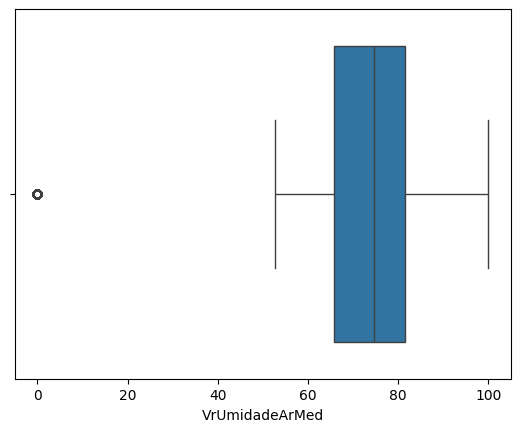

In [ ]:
#VrUmidadeArMed:5165
sns.boxplot(x= df["VrUmidadeArMed"])
df = df.drop(df[(df.VrUmidadeArMed < 50)].index)
df.count()

VrNivel           5055
VlVolume          5055
PcVolume          5055
VzQJusante        5055
VzQNatural        5055
VrChuva           5055
DdDia             5055
MmMes             5055
AaAno             5055
VrTempMin         2772
VrTempMed         2784
VrTempMax         2784
VrUmidadeArMin    2784
VrUmidadeArMed    2784
VrUmidadeArMax    2784
VrPrecipitacao    2784
dtype: int64

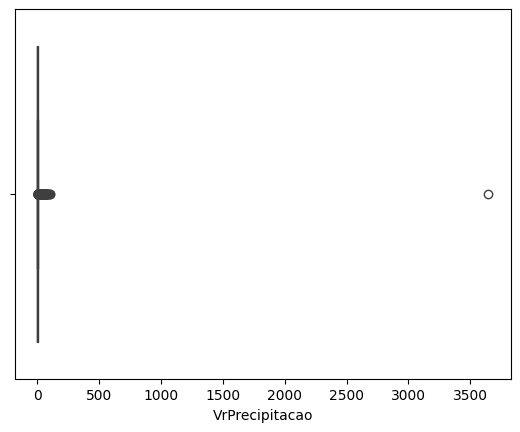

In [ ]:
#VrPrecipitacao:4480
sns.boxplot(x= df["VrPrecipitacao"])
df = df.drop(df[(df.VrPrecipitacao > 0.6)].index)
df.count()

VrNivel           5038
VlVolume          5038
PcVolume          5038
VzQJusante        5038
VzQNatural        5038
VrChuva           5038
DdDia             5038
MmMes             5038
AaAno             5038
VrTempMin         2755
VrTempMed         2767
VrTempMax         2767
VrUmidadeArMin    2767
VrUmidadeArMed    2767
VrUmidadeArMax    2767
VrPrecipitacao    2767
dtype: int64

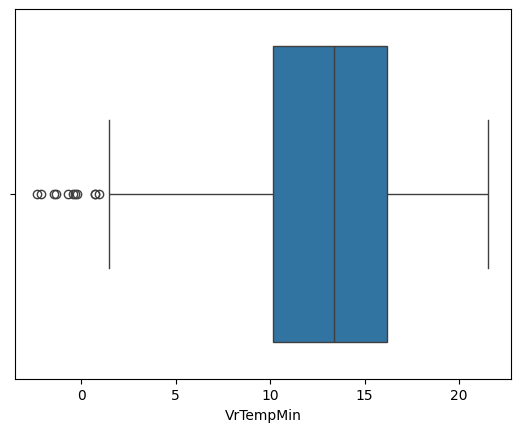

In [ ]:
#VrTempMin:3164
sns.boxplot(x= df["VrTempMin"])
df = df.drop(df[(df.VrTempMin <= 2)].index)
df.count()

VrNivel           5038
VlVolume          5038
PcVolume          5038
VzQJusante        5038
VzQNatural        5038
VrChuva           5038
DdDia             5038
MmMes             5038
AaAno             5038
VrTempMin         2755
VrTempMed         2767
VrTempMax         2767
VrUmidadeArMin    2767
VrUmidadeArMed    2767
VrUmidadeArMax    2767
VrPrecipitacao    2767
dtype: int64

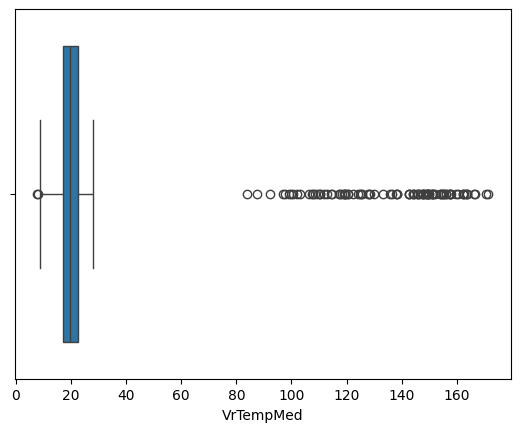

In [ ]:
#VrTempMed:3159
sns.boxplot(x= df["VrTempMed"])
df.drop(df[((df.VrTempMed < 2) | (df.VrTempMed >= 30))].index)
df.count()

VrNivel           5025
VlVolume          5025
PcVolume          5025
VzQJusante        5025
VzQNatural        5025
VrChuva           5025
DdDia             5025
MmMes             5025
AaAno             5025
VrTempMin         2754
VrTempMed         2754
VrTempMax         2754
VrUmidadeArMin    2754
VrUmidadeArMed    2754
VrUmidadeArMax    2754
VrPrecipitacao    2754
dtype: int64

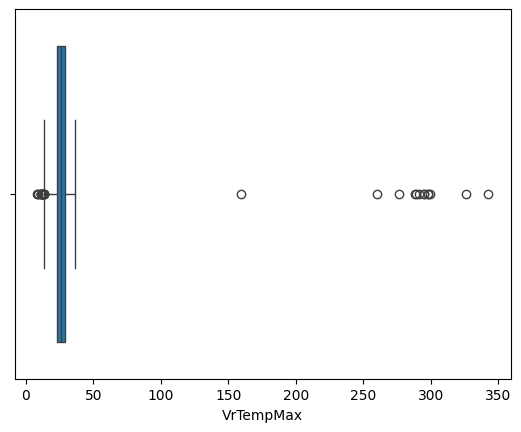

In [ ]:
#VrTempMax:3159
sns.boxplot(x= df["VrTempMax"])
df = df.drop(df[((df.VrTempMax < 0) | (df.VrTempMax >= 40))].index)
df.count()

VrNivel           4954
VlVolume          4954
PcVolume          4954
VzQJusante        4954
VzQNatural        4954
VrChuva           4954
DdDia             4954
MmMes             4954
AaAno             4954
VrTempMin         2683
VrTempMed         2683
VrTempMax         2683
VrUmidadeArMin    2683
VrUmidadeArMed    2683
VrUmidadeArMax    2683
VrPrecipitacao    2683
dtype: int64

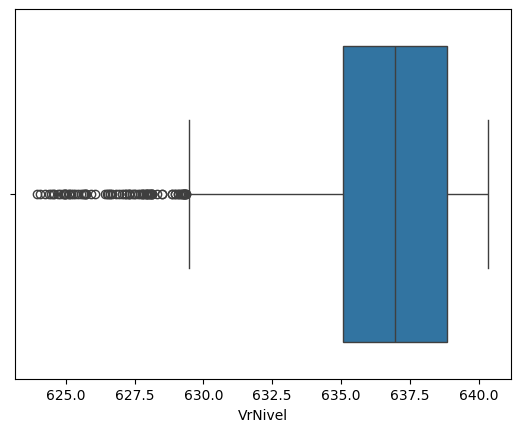

In [ ]:
#VrNivel:6541
sns.boxplot(x= df["VrNivel"])
df = df.drop(df[(df.VrNivel <= 629)].index)
df.count()

VrNivel           4934
VlVolume          4934
PcVolume          4934
VzQJusante        4934
VzQNatural        4934
VrChuva           4934
DdDia             4934
MmMes             4934
AaAno             4934
VrTempMin         2663
VrTempMed         2663
VrTempMax         2663
VrUmidadeArMin    2663
VrUmidadeArMed    2663
VrUmidadeArMax    2663
VrPrecipitacao    2663
dtype: int64

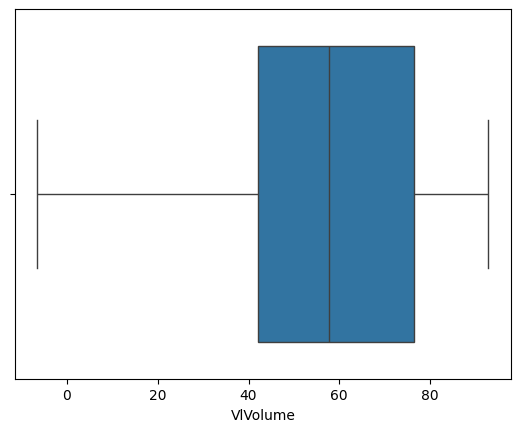

In [ ]:
#VlVolume:6454
sns.boxplot(x= df["VlVolume"])
df = df.drop(df[(df.VlVolume < 0)].index)
df.count()

VrNivel           4934
VlVolume          4934
PcVolume          4934
VzQJusante        4934
VzQNatural        4934
VrChuva           4934
DdDia             4934
MmMes             4934
AaAno             4934
VrTempMin         2663
VrTempMed         2663
VrTempMax         2663
VrUmidadeArMin    2663
VrUmidadeArMed    2663
VrUmidadeArMax    2663
VrPrecipitacao    2663
dtype: int64

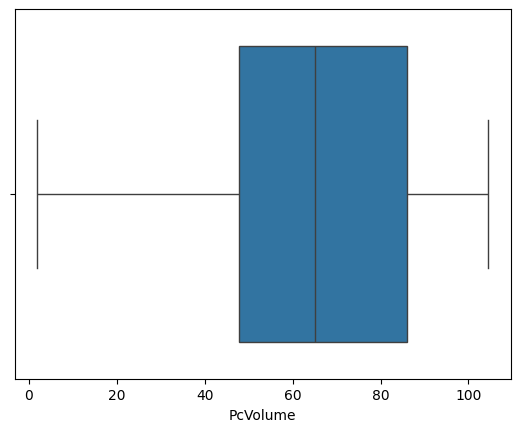

In [ ]:
#PcVolume:6454
sns.boxplot(x= df["PcVolume"])
df.count()

VrNivel           4880
VlVolume          4880
PcVolume          4880
VzQJusante        4880
VzQNatural        4880
VrChuva           4880
DdDia             4880
MmMes             4880
AaAno             4880
VrTempMin         2621
VrTempMed         2621
VrTempMax         2621
VrUmidadeArMin    2621
VrUmidadeArMed    2621
VrUmidadeArMax    2621
VrPrecipitacao    2621
dtype: int64

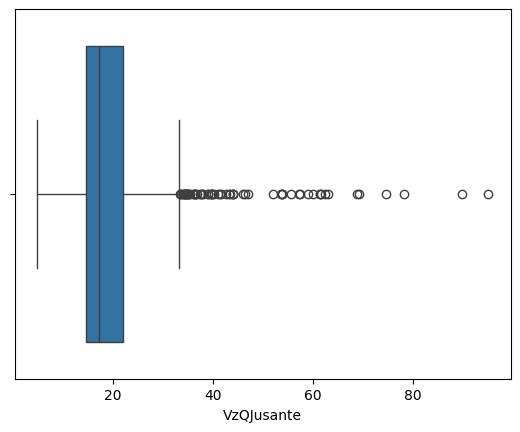

In [ ]:
#VzQJusante:6430
sns.boxplot(x= df["VzQJusante"])
df = df.drop(df[(df.VzQJusante >= 35)].index)
df.count()

VrNivel           4521
VlVolume          4521
PcVolume          4521
VzQJusante        4521
VzQNatural        4521
VrChuva           4521
DdDia             4521
MmMes             4521
AaAno             4521
VrTempMin         2414
VrTempMed         2414
VrTempMax         2414
VrUmidadeArMin    2414
VrUmidadeArMed    2414
VrUmidadeArMax    2414
VrPrecipitacao    2414
dtype: int64

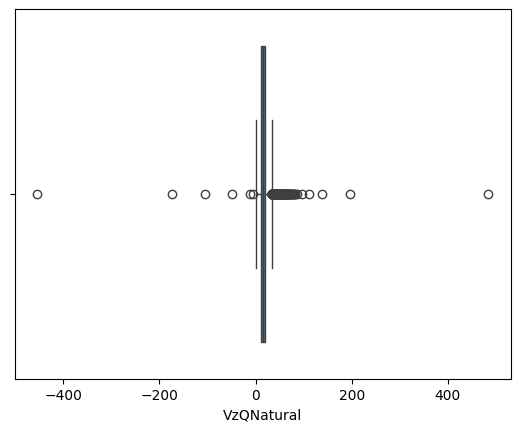

In [ ]:
#VzQNatural:6341
sns.boxplot(x= df["VzQNatural"])
df = df.drop(df[((df.VzQNatural < -2) | (df.VzQNatural >= 30))].index)
df.count()

VrNivel           3971
VlVolume          3971
PcVolume          3971
VzQJusante        3971
VzQNatural        3971
VrChuva           3971
DdDia             3971
MmMes             3971
AaAno             3971
VrTempMin         2302
VrTempMed         2302
VrTempMax         2302
VrUmidadeArMin    2302
VrUmidadeArMed    2302
VrUmidadeArMax    2302
VrPrecipitacao    2302
dtype: int64

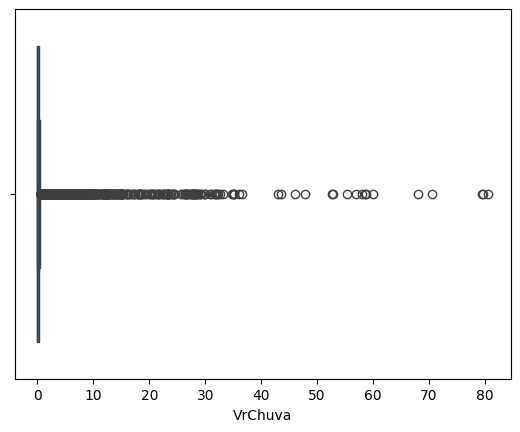

In [ ]:
#VrChuva:5804
sns.boxplot(x= df["VrChuva"])
df = df.drop(df[(df.VrChuva > 2)].index)
df.count()

##### Tratando missings

In [ ]:
count_is_null(df)

VrNivel:0
VlVolume:0
PcVolume:0
VzQJusante:0
VzQNatural:0
VrChuva:0
DdDia:0
MmMes:0
AaAno:0
VrTempMin:1669
VrTempMed:1669
VrTempMax:1669
VrUmidadeArMin:1669
VrUmidadeArMed:1669
VrUmidadeArMax:1669
VrPrecipitacao:1669


##### Tratando valores nulos

In [ ]:
col_list = ['VrTempMin', 'VrTempMed','VrTempMax', 'VrUmidadeArMin', 'VrUmidadeArMed', 'VrUmidadeArMax','VrPrecipitacao']
for coluna in df.columns:
    # Identifique as colunas com NaN
    if df[coluna].isnull().any():
        # Calcule a média dos valores não nulos do ano anterior e mesmo mês
        media_mes_ano_anterior = df.groupby(['AaAno', 'MmMes'])[coluna].shift().groupby(df['AaAno']).transform('mean')
        
        # Calcule a média geral de todos os anos para os valores não nulos
        media_geral = df[coluna].mean()
        
        # Preencha os valores NaN na coluna específica com a média do ano e mês anterior,
        # e, caso não exista ano anterior, preencha com a média geral
        df[coluna] = df[coluna].fillna(media_mes_ano_anterior.fillna(media_geral))
df

,VrNivel,VlVolume,PcVolume,VzQJusante,VzQNatural,VrChuva,DdDia,MmMes,AaAno,VrTempMin,VrTempMed,VrTempMax,VrUmidadeArMin,VrUmidadeArMed,VrUmidadeArMax,VrPrecipitacao
1,636.97,57.541706,64.783695,28.79,24.746363,0.2,6,11,2023,9.480000,15.660000,21.840000,47.170000,73.585000,100.000000,0.00000
4,637.07,58.486002,65.846837,31.81,25.303422,0.0,3,11,2023,14.200000,16.630000,19.060000,74.500000,87.250000,100.000000,0.00000
7,637.34,61.062383,68.747472,32.66,25.357270,0.2,31,10,2023,20.330000,24.820000,29.310000,47.830000,73.915000,100.000000,0.25400
11,637.73,64.855204,73.017643,32.35,22.576889,0.0,27,10,2023,14.660000,17.425000,20.190000,77.700000,88.850000,100.000000,0.00000
14,637.98,67.332638,75.806878,32.23,23.963573,1.4,24,10,2023,14.060000,21.285000,28.510000,36.020000,68.010000,100.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8654,639.87,87.353099,98.347041,28.48,21.961466,0.0,27,2,2000,12.608331,23.254166,25.381077,49.087107,73.141034,97.194961,0.07408
8655,639.92,87.916301,98.981125,30.06,22.209458,0.0,26,2,2000,12.608331,23.254166,25.381077,49.087107,73.141034,97.194961,0.07408
8681,638.95,77.309538,87.039434,19.98,23.656597,0.0,31,1,2000,12.608331,23.254166,25.381077,49.087107,73.141034,97.194961,0.07408
8682,638.92,76.991880,86.681796,18.82,15.143403,0.0,30,1,2000,12.608331,23.254166,25.381077,49.087107,73.141034,97.194961,0.07408


In [ ]:
count_is_null(df)

VrNivel:0
VlVolume:0
PcVolume:0
VzQJusante:0
VzQNatural:0
VrChuva:0
DdDia:0
MmMes:0
AaAno:0
VrTempMin:0
VrTempMed:0
VrTempMax:0
VrUmidadeArMin:0
VrUmidadeArMed:0
VrUmidadeArMax:0
VrPrecipitacao:0


In [ ]:
def normal_test(df:pd.DataFrame) -> None:
    """Função realiza teste de shapiro (recomendável apenas para bases pequenas) em todas as colunas do Dataframe. Shapiro: Teste de normalidade
    dos dados, caso o pValor do teste seja maior ou igual à 0,05, significa que estes dados podem ser
    tidos como provenientes de uma distribuição normal.

    Args:
        df (pd.DataFrame): Dataframe raw, sem nenhum tratamento inicial.
        cols (List[str]): Lista contendo todos os nomes de colunas que precisam ser transformadas para float.
        new_col_names (List[str]): Lista com os novos nomes para as colunas do Dataframe, seguindo regras definida.
    """
    for col in df:
        if shapiro(df[col]).pvalue >= 0.05:
            print(f"coluna {col} {shapiro(df[col]).pvalue}.Normal")
        print(f"coluna {col} {shapiro(df[col]).pvalue}. Não Normal")

In [ ]:
# Pearson's: corr: Paramétrico
# Spearman: não-paramétricos
normal_test(df)

coluna VrNivel 2.206468688016853e-36. Não Normal
coluna VlVolume 5.156772053392065e-32. Não Normal
coluna PcVolume 5.15723637366064e-32. Não Normal
coluna VzQJusante 1.6817177016197233e-31. Não Normal
coluna VzQNatural 1.4577507230847845e-27. Não Normal
coluna VrChuva 0.0. Não Normal
coluna DdDia 3.66859202558803e-36. Não Normal
coluna MmMes 8.92417406014329e-30. Não Normal
coluna AaAno 2.989858114893543e-36. Não Normal
coluna VrTempMin 7.838659131961112e-37. Não Normal
coluna VrTempMed 0.0. Não Normal
coluna VrTempMax 1.5258738978032933e-41. Não Normal
coluna VrUmidadeArMin 2.7827536455637776e-37. Não Normal
coluna VrUmidadeArMed 1.1378064846762101e-37. Não Normal
coluna VrUmidadeArMax 0.0. Não Normal
coluna VrPrecipitacao 0.0. Não Normal


In [ ]:
df.corr()

,VrNivel,VlVolume,PcVolume,VzQJusante,VzQNatural,VrChuva,DdDia,MmMes,AaAno,VrTempMin,VrTempMed,VrTempMax,VrUmidadeArMin,VrUmidadeArMed,VrUmidadeArMax,VrPrecipitacao
VrNivel,1.000000,0.997949,0.997949,0.327751,0.472085,-0.055538,0.039128,-0.459786,0.254105,-0.107173,0.023439,-0.120635,0.058910,0.082990,0.250414,-0.022387
VlVolume,0.997949,1.000000,1.000000,0.339438,0.483868,-0.056501,0.041260,-0.471396,0.258713,-0.103399,0.022900,-0.118734,0.061883,0.085730,0.247997,-0.022486
PcVolume,0.997949,1.000000,1.000000,0.339438,0.483868,-0.056501,0.041260,-0.471396,0.258713,-0.103399,0.022900,-0.118734,0.061883,0.085730,0.247997,-0.022486
VzQJusante,0.327751,0.339438,0.339438,1.000000,0.547460,-0.015839,0.015233,-0.232010,0.203133,0.097140,-0.031632,0.033626,0.082916,0.067597,-0.159420,-0.021465
VzQNatural,0.472085,0.483868,0.483868,0.547460,1.000000,0.095817,0.025025,-0.298943,0.434292,0.194564,-0.050157,-0.036215,0.206034,0.208224,0.022614,0.053874
VrChuva,-0.055538,-0.056501,-0.056501,-0.015839,0.095817,1.000000,0.012911,0.064107,-0.012438,0.090427,-0.020162,-0.065236,0.133513,0.131919,-0.016688,0.171224
DdDia,0.039128,0.041260,0.041260,0.015233,0.025025,0.012911,1.000000,-0.072890,-0.047021,0.010148,-0.016370,0.003708,-0.002233,-0.001925,0.003206,0.018202
MmMes,-0.459786,-0.471396,-0.471396,-0.232010,-0.298943,0.064107,-0.072890,1.000000,-0.225481,-0.141264,-0.023596,-0.139821,0.008601,0.003890,-0.049004,0.019106
AaAno,0.254105,0.258713,0.258713,0.203133,0.434292,-0.012438,-0.047021,-0.225481,1.000000,0.059145,-0.005900,-0.009985,0.006602,0.018596,0.124755,-0.058873
VrTempMin,-0.107173,-0.103399,-0.103399,0.097140,0.194564,0.090427,0.010148,-0.141264,0.059145,1.000000,-0.227126,0.474278,0.246095,0.215804,-0.315281,0.016354


##### Dados não-normais
- Como nossos dados retornaram p-valor<=0,05 precisamos fazer sua normalização e para isto usarmos o boxcox e Powertranform, porém, tivemos muitos erros já que todos dados precisavam sr convrtidos. Optamos portanto, pela escolha de modelos não-paramétricos

In [ ]:
x = df[['AaAno', 'MmMes', 'DdDia',"VzQJusante", "VzQNatural","VrChuva", 'VrTempMin', 'VrTempMed','VrTempMax', 'VrUmidadeArMin', 'VrUmidadeArMed', 'VrUmidadeArMax','VrPrecipitacao']]
y = df['VrNivel']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
y_pred = tree_model.predict(x_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
print(f'rmse:{rmse}, r2:{r2}')

rmse:1.0135277508178326, r2:0.8062412796948224


In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'rmse:{rmse}, r2:{r2}')

rmse:0.7329208001903514, r2:0.8986779278706971


In [ ]:
forest_model = RandomForestRegressor(random_state=42)
forest_model.fit(x_train, y_train)
feature_importances = list(zip(x_train.columns, forest_model.feature_importances_))
for feature, importance in feature_importances:
    print(f'{feature}: {importance}')

AaAno: 0.1936452943756041
MmMes: 0.3939393300172057
DdDia: 0.024948546464241744
VzQJusante: 0.11076956766671252
VzQNatural: 0.1603806450850261
VrChuva: 0.0028652956489682237
VrTempMin: 0.028967705137606645
VrTempMed: 0.01156134376914812
VrTempMax: 0.014164213116936917
VrUmidadeArMin: 0.00925520924346177
VrUmidadeArMed: 0.01029797238643453
VrUmidadeArMax: 0.03620856217172634
VrPrecipitacao: 0.0029963149169273174


In [ ]:
# Criar um objeto DMatrix
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Parâmetros do modelo
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror',  # Problema de regressão
}

# Treinar o modelo
num_round = 100
model = xgb.train(params, dtrain, num_round)

In [ ]:
predictions = model.predict(dtest)

# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'rmse:{rmse}, r2:{r2}')

rmse:0.8715327736396948, r2:0.8567292893082376


In [ ]:
model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=20)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

In [ ]:
#transformando todos dados de entrada para um valor dimensionado entre 0 e 1
#scaler = MinMaxScaler()
#x_scaled = scaler.fit_transform(x)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
#Transformandopara variáveis não normais em uma distribuicão normal
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True) #método usado para variaveis negativas e positivas

x_train_transformed = power_transformer.fit_transform(x_train)
x_test_transformed = power_transformer.transform(x_test)

y_train_transformed, lambda_value = boxcox(y_train + 1)  # Adicionando 1 para lidar com valores zero, se houver
y_test_transformed, lambda_value = boxcox(y_test + 1)

/Users/monicaborges/Documents/modelo_sabesp/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/monicaborges/Documents/modelo_sabesp/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [ ]:
model = LinearRegression()
model.fit(x_train_transformed, y_train_transformed)

LinearRegression()

In [ ]:
y_pred = model.predict(x_test_transformed)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_transformed, y_pred))
print(f'RMSE após MinMaxScaler, PowerTransformer e treinamento do modelo: {rmse}')

RMSE após MinMaxScaler, PowerTransformer e treinamento do modelo: inf


/Users/monicaborges/Documents/modelo_sabesp/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [ ]:
#modelo com todas variáveis
model2_formula = 'VrNivel~AaAno+MmMes+DdDia+VlVolume+PcVolume+VzQJusante+VzQNatural+VrChuva+VrTempMin+VrTempMed+VrTempMax+VrUmidadeArMin+VrUmidadeArMed+VrUmidadeArMax+VrPrecipitacao+1'
model2 = ols(formula=model2_formula, data=df_train_transformed).fit()
print(model2.summary())
#Explicacao:

                            OLS Regression Results                            
Dep. Variable:                VrNivel   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 5.737e+04
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:59:18   Log-Likelihood:            -9.7119e+05
No. Observations:                2779   AIC:                         1.942e+06
Df Residuals:                    2763   BIC:                         1.942e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       1.323e+153  2.74e+149   48

/Users/monicaborges/Documents/modelo_sabesp/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1094: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/Users/monicaborges/Documents/modelo_sabesp/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/monicaborges/Documents/modelo_sabesp/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1092: RuntimeWarning: overflow encountered in square
  s = s**2
/Users/monicaborges/Documents/modelo_sabesp/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1529: RuntimeWarning: overflow encountered in multiply
  cov_p = self.normalized_cov_params * scale


In [ ]:
linear_model = LinearRegression()

In [ ]:
linear_model.fit(x_train_transformed, y_train_transformed)

LinearRegression()

In [ ]:
y_pred = linear_model.predict(x_test_transformed)

In [ ]:
df_test_transformed

,AaAno,MmMes,DdDia,VlVolume,PcVolume,VzQJusante,VzQNatural,VrChuva,VrTempMin,VrTempMed,VrTempMax,VrUmidadeArMin,VrUmidadeArMed,VrUmidadeArMax,VrPrecipitacao
0,0.279320,0.946944,-0.407200,-0.088926,-0.088926,1.266194,-0.168101,-0.497898,-0.129870,-0.527376,-0.255665,-0.445027,-0.421167,0.267269,-1.021685
1,-1.203069,0.946944,0.987889,-1.973032,-1.973032,-1.435008,-1.574251,1.653947,-0.076750,0.543498,-0.018522,-0.023900,-0.026058,0.019062,0.509158
2,0.138916,0.946944,-1.210954,-1.469605,-1.469605,0.758077,-0.957705,-0.497898,1.154496,0.215993,0.509325,0.472021,0.376754,-0.971078,-1.021685
3,-0.146598,0.222806,-0.075113,1.183704,1.183704,1.614112,0.733680,-0.497898,-1.380710,-3.297196,-3.066806,2.168609,1.895986,-3.242989,-1.021685
4,-0.891143,-0.124915,0.142644,0.488825,0.488825,-0.379212,-0.808378,-0.497898,-0.076750,0.543498,-0.018522,-0.023900,-0.026058,0.019062,0.509158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.279320,-1.413164,-0.861145,0.914977,0.914977,-0.680316,1.078919,-0.497898,1.937867,0.619415,1.134139,1.048788,1.039654,-0.058568,1.682406
1188,0.826588,0.580179,0.675464,-1.228641,-1.228641,-0.461236,-0.906620,-0.497898,-0.282853,0.121988,1.536524,-1.537442,-1.687811,-1.565522,-1.021685
1189,-1.362476,0.580179,0.034115,-1.017766,-1.017766,-1.185263,-0.911100,1.954771,-0.076750,0.543498,-0.018522,-0.023900,-0.026058,0.019062,0.509158
1190,-1.688830,1.322859,-1.093397,-1.237678,-1.237678,-0.830669,-1.046600,2.166602,-0.076750,0.543498,-0.018522,-0.023900,-0.026058,0.019062,0.509158


In [ ]:
rmse = mean_squared_error(y_test_transformed, y_pred, squared=False)
r2 = r2_score(y_test_transformed, y_pred)
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

In [ ]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Adicione variáveis com p-value abaixo do limiar de entrada
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Adicionando {best_feature} com p-value {best_pval}')
        
        # Remova variáveis com p-value acima do limiar de saída
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Removendo {worst_feature} com p-value {worst_pval}')
        
        if not changed:
            break
    return included

In [ ]:
selected_features = stepwise_selection(pd.DataFrame(x_train_transformed, columns=x_train.columns), y_train_transformed)

Adicionando VlVolume com p-value 0.0
Adicionando MmMes com p-value 2.866774113245573e-11
Adicionando VzQJusante com p-value 7.624862851261391e-09
Adicionando VzQNatural com p-value 0.0009730413282467196


In [ ]:
model = catboost.CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, loss_function='MultiClass')

# Treinar o modelo
model.fit(x_train, y_train)

# Fazer previsões no conjunto de teste
predictions = model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE do modelo: {rmse}')

# Calcular o R²
r2 = r2_score(y_test, predictions)
print(f'R² do modelo: {r2}')

0:	learn: 6.6856213	total: 816ms	remaining: 1m 20s
1:	learn: 6.6558597	total: 1.52s	remaining: 1m 14s
2:	learn: 6.6168105	total: 2.21s	remaining: 1m 11s
3:	learn: 6.5876504	total: 2.9s	remaining: 1m 9s
4:	learn: 6.5570033	total: 3.6s	remaining: 1m 8s
5:	learn: 6.5313269	total: 4.29s	remaining: 1m 7s
6:	learn: 6.5013383	total: 4.93s	remaining: 1m 5s
7:	learn: 6.4802127	total: 5.63s	remaining: 1m 4s
8:	learn: 6.4536022	total: 6.31s	remaining: 1m 3s
9:	learn: 6.4284758	total: 6.96s	remaining: 1m 2s
10:	learn: 6.4040502	total: 7.58s	remaining: 1m 1s
11:	learn: 6.3798797	total: 8.27s	remaining: 1m
12:	learn: 6.3580734	total: 8.95s	remaining: 59.9s
13:	learn: 6.3327441	total: 9.64s	remaining: 59.2s
14:	learn: 6.3052306	total: 10.3s	remaining: 58.6s
15:	learn: 6.2781624	total: 11s	remaining: 57.9s
16:	learn: 6.2527306	total: 11.7s	remaining: 57.3s
17:	learn: 6.2271902	total: 12.4s	remaining: 56.5s
18:	learn: 6.2041930	total: 13.1s	remaining: 55.9s
19:	learn: 6.1824849	total: 13.8s	remaining: 

In [ ]:
rmse = sqrt(mean_squared_error(y_test_transformed, y_pred_transformed))
print(rmse)

##### Dividindo dados

##### modelo base: Média

In [ ]:
modelo_media_mse = statistics.mean((transformed_df['VrNivel'] - statistics.mean(df['VrNivel']))**2)
modelo_media_rmse = math.sqrt(modelo_media_mse)
modelo_media_rmse

636.7989790834395

In [ ]:
x_train, x_test, y_train, y_test = transformed_df(x, y, test_size=0.3, random_state=0)

,VrNivel,VlVolumeHm,PcVolume%,VzQJusante,VzQNatural,VrChuva,DdDia,MmMes,AaAno
0,0.820028,0.820246,0.820266,-0.171502,0.822810,0.130169,-1.888092,0.121252,1.720968
1,0.801558,0.800041,0.800064,-0.165419,0.176938,1.758223,1.491752,-0.194375,1.720968
2,0.807709,0.806768,0.806789,-0.227052,-0.272272,-0.764579,1.397787,-0.194375,1.720968
3,0.820028,0.820246,0.820266,-0.093759,-0.047284,0.130169,1.303028,-0.194375,1.720968
4,0.832367,0.833760,0.833778,-1.143506,-0.431849,0.130169,1.207441,-0.194375,1.720968
...,...,...,...,...,...,...,...,...,...
1658,0.308768,0.271531,0.271607,0.706414,0.197510,-0.764579,-1.251543,0.121252,-1.807650
1659,0.320239,0.283596,0.283672,0.684305,-0.048884,-0.764579,-1.396354,0.121252,-1.807650
1660,0.337482,0.301754,0.301829,0.594424,0.253913,1.842202,-1.548716,0.121252,-1.807650
1661,0.343239,0.307823,0.307897,0.588914,-0.445203,-0.764579,-1.711118,0.121252,-1.807650


In [ ]:
shapiro(test_df['VlVolumeHm'])

ShapiroResult(statistic=0.9507067799568176, pvalue=3.297330983196357e-23)

<Axes: >

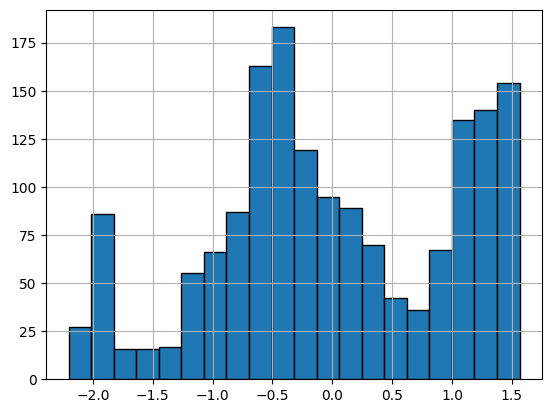

In [ ]:
test_df["VlVolumeHm"].hist(edgecolor="black", bins=20)

In [ ]:
test_df.corr()

,VrNivel,VlVolumeHm,PcVolume%,VzQJusante,VzQNatural,VrChuva,DdDia,MmMes,AaAno
VrNivel,1.000000,0.998217,0.998221,0.378660,0.454641,-0.054819,0.019809,-0.448305,0.518637
VlVolumeHm,0.998217,1.000000,1.000000,0.385306,0.458611,-0.056271,0.019973,-0.461932,0.507539
PcVolume%,0.998221,1.000000,1.000000,0.385297,0.458606,-0.056269,0.019972,-0.461919,0.507559
VzQJusante,0.378660,0.385306,0.385297,1.000000,0.526446,0.002471,-0.002096,-0.388632,-0.065013
VzQNatural,0.454641,0.458611,0.458606,0.526446,1.000000,0.240655,-0.016009,-0.406020,0.197880
VrChuva,-0.054819,-0.056271,-0.056269,0.002471,0.240655,1.000000,-0.041843,-0.017017,0.117223
DdDia,0.019809,0.019973,0.019972,-0.002096,-0.016009,-0.041843,1.000000,-0.038939,0.001624
MmMes,-0.448305,-0.461932,-0.461919,-0.388632,-0.406020,-0.017017,-0.038939,1.000000,-0.252346
AaAno,0.518637,0.507539,0.507559,-0.065013,0.197880,0.117223,0.001624,-0.252346,1.000000


##### Séries Temporais: Para o que servem
- Avaliar o comportamento de uma variável para um período de tempo especifico
- Detectar se há algum padrão nos acontecimentos
- Detectar se há uma mudança brusca nos acontecimentos

##### Etapas
- Realizar todos tratamentos paramétricos antes
- Transformar dados transacionais em uma série de tempo. Para isto:
    - Definir o nível: [nível da agua e intervalo de tempo]
